In [78]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from matplotlib import image
from gym import Env, spaces
import time
import math
import seaborn as sns

# https://blog.paperspace.com/creating-custom-environments-openai-gym/

In [24]:
img = image.imread(r"cadaver_slice_160.png")

(0, 255)
(0, 1)


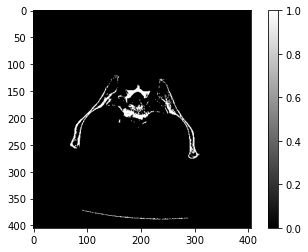

In [25]:
I = img
I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

img = Image.fromarray(I8)
print(img.getextrema())
img = img.point(lambda p: p > 160)
print(img.getextrema())

plt.imshow(img, cmap ='gray')
plt.colorbar()
plt.show()


In [26]:
print(img.size)

(405, 405)


# Create Environment

In [147]:
class Center_FOV(Env):

    ACTION = ["Right", "Left", "Down", "Up", "Do Nothing"]

    def __init__(self):
        super(Center_FOV, self).__init__()

        # get image and threshold it. This will be the backgroud. 
        img = image.imread(r"cadaver_slice_160.png")
        I = img#[100:300, 50:350]
        
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        print(img.getextrema())
        img = img.point(lambda p: p > 160)
        # PIL Image:(left, upper, right, lower)
        
        # define image dimensions: 
        self.left = 100
        self.right = 350
        self.upper = 100
        self.lower = 300
        img = img.crop((self.left, self.upper, self.right, self.lower))
        #print(img.size)



        DISCRETE_Observation_size = []
        

        # Define a 2-D observation space
        self.observation_shape = img.size

        # I think the highest observation space would be either all ones, where the reward at each position would be FOV_h*FOV_w
        # the lowest observation space would be all zeros, where the reward at each position would be zero. 
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(5,)
                        
        # Create a canvas to render the environment images upon 
        self.canvas = img

        # current FOV: This is what will be displayed until we reach the optimal position. 
        self.current_FOV = img
        
        # define reward
        self.reward = 0
        self.max_reward = 0
        


        # Permissible area of the FOV viewer to be 
        self.y_min = 0#int (self.observation_shape[0])
        print(self.y_min)
        self.x_min = 0#int (self.observation_shape[1])
        print(self.x_min)
        self.y_max = int (self.observation_shape[0])
        print(self.y_max)
        self.x_max = int (self.observation_shape[1])
        print(self.x_max)

    def reset(self):

        # Reset the reward
        self.reward = 0
        self.max_reward = 0

        # Reset the Canvas 
        img = image.imread(r"cadaver_slice_160.png")
        #I = img
        I = img#[100:300, 50:350]
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        #print(img.getextrema())
        img = img.point(lambda p: p > 160)
        #img = img[100:300, 50:350]
        img = img.crop((self.left, self.upper, self.right, self.lower))
        self.canvas = img

        plt.imshow(self.canvas, cmap = 'gray')
        plt.show()



        

        # Intialise the chopper
        #self.grabber = FOV_grabber("FOV_Grabber", self.x_max, self.x_min, self.y_max, self.y_min)
        self.grabber = FOV_Viewer("FOV_Grabber", self.x_max, self.x_min, self.y_max, self.y_min)
        # Determine a place to intialise the chopper in
        x = random.randrange(0, int(self.observation_shape[0] - self.grabber.FOV_w))
        y = random.randrange(0, int(self.observation_shape[1] - self.grabber.FOV_h))
        #print(x)
        #print(y)
        self.grabber.set_position(x,y)
        print(self.grabber.get_position())


        # return the observation
        self.current_FOV = self.canvas.crop((self.grabber.x, self.grabber.y, self.grabber.x+self.grabber.FOV_w,self.grabber.y+self.grabber.FOV_h))
        
        return self.current_FOV
        #return self.canvas[self.grabber.x:self.grabber.x+self.grabber.FOV_w, self.grabber.y:self.grabber.y+self.grabber.FOV_h]

    # used to render our observations on the screen. 
    def render(self, mode = 'human'):
        assert mode in ['human', 'rgb_array'], "Invalid mode, must be either \"human\" or \"rgb_array\""

        if mode == 'human':
            plt.imshow(self.current_FOV)
            plt.show()
        
        elif mode == 'rgb_array':
            return self.current_FOV

    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}



    # This is the step function which steps for our FOV
    def step(self, action):

        # episode done? 
        done = False
        #Assert that an action is valid. 
        assert self.action_space.contains(action), "Invalid Action"

        # get the current reward, which is the sum of all pixels. 
        # previous_state_reward = int(np.sum(self.current_FOV))
        
        
        self.step_size = 10

        # apply action to the FOV grabber so it can move. 
        if action == 0:
            self.grabber.move(0, self.step_size)
        elif action == 1:
            self.grabber.move(0, -self.step_size)  
        elif action == 2:
            self.grabber.move(self.step_size, 0)  
        elif action == 3:
            self.grabber.move(-self.step_size, 0)  
        elif action == 4:
            self.grabber.move(0, 0)  

         # update the new position of the FOV. 
        self.current_FOV = self.canvas.crop((self.grabber.x, self.grabber.y, self.grabber.x+self.grabber.FOV_w,self.grabber.y+self.grabber.FOV_h))
        self.reward = np.sum(self.current_FOV)




        # # get sum of pixels after moving. 
        # new_state_reward =int( np.sum(self.current_FOV)) 

        # print((new_state_reward - previous_state_reward) )

        # # calculate difference. 
        # if (new_state_reward < previous_state_reward):
        #     # to deal with negative integers. 
        #     self.reward -=(previous_state_reward - new_state_reward) 
        # else: 
        #     # update the reward, we want to move toward the region of maximum pixels or highest reward. 
        #     self.reward +=(new_state_reward - previous_state_reward) 

        # everytime we move, the reward is decremented. 
        #self.reward -= 1

        # if the current reward is not greater than the max reward, then we are going in the wrong direction, and we add a penalty of -1
        

        #update max reward
        if self.reward >= self.max_reward:
            self.max_reward = self.reward
        # otherwise, if it is not greater, then we will need to add some sort of penalty to the max reward. We want to maximize the max reward. 
        # basically for every step that is not in the direction of increasing pixels, we need to decrement the max reward. 
        else:
            self.max_reward -=1 

            #self.max_reward -=np.floor(0.1*self.max_reward)

        # The reward will be the sum of the pixels. 
        self.reward += np.sum(self.current_FOV)

        # Incremenet the episodic return
        # self.ep_return += 1

        # Stopping condition needs to be refined to a maximum. 
        if self.max_reward > 1000:
            print(f'finished with reward: {self.reward}')
            done = True

        return self.current_FOV, self.max_reward, done


    # def render(self, mode = "human"):
    #     assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
    #     if mode == "human":
    #         cv2.imshow("Game", self.canvas)
    #         cv2.waitKey(10)
        
    #     elif mode == "rgb_array":
    #         return self.canvas

(0, 255)
0
0
250
200


C:\Users\asong18\Anaconda3\envs\deeplearning\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


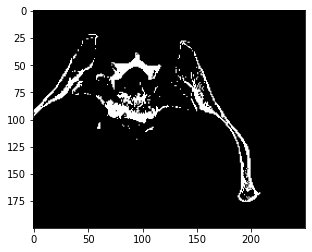

54
yolo
9
(54, 9)


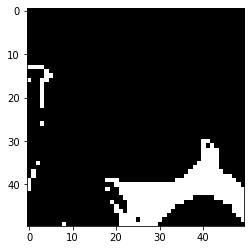

position = <method-wrapper '__ne__' of method object at 0x0000017489C00980>


In [123]:
env = Center_FOV()
obs = env.reset()

plt.imshow(obs, cmap = 'gray')
#plt.colorbar()
plt.show()
print(env.)
print(f'position = {env.grabber.get_position.__ne__}')

# count = 0
# while True: 

#     # take random action
#     action = env.action_space.sample()
#     obs, reward, done = env.step(action)

#     print(f"current reward is: {reward}")

#     screen = env.render(mode = "rgb_array")
#     plt.imshow(screen, cmap = 'gray')
#     plt.show()
#     count +=1
#     if done == True or count == 10:
#         break
# env.close()


# while True: 

#     # take random action
#     action = env.action_space.sample()
#     obs, reward, done = env.step(action)

#     print(f"current reward is: {reward}")

#     screen = env.render(mode = "rgb_array")
#     plt.imshow(screen, cmap = 'gray')
#     plt.show()

#     if done == True:
#         break
# env.close()
        

In [ ]:
env = Center_FOV()
obs = env.reset()
plt.imshow(obs, cmap = 'gray')
#plt.colorbar()
plt.show()

screen = env.render(mode = "rgb_array")
plt.imshow(screen, cmap = 'gray')
plt.show()
# cv2 does not work. 
# cv2.imshow("game", obs)
# cv2.waitKey(10)
# cv2.destroyAllWindows()

# This is a class FOV Viewer, this will be determining the FOV and then calculating the total pixel values. 

In [28]:
class FOV_Viewer(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        self.FOV_w = 50
        self.FOV_h = 50
    
    def set_position(self, x, y):
        self.x = x #self.clamp(self.x, self.x_min, self.x_max - self.FOV_w)
        print(x)
        print('yolo')
        print(y)
        self.y = y #self.clamp(self.y, self.y_min, self.y_max - self.FOV_h)
        
        # count = (self.canvas[x:self.FOV_w, y:y+self.FOV_h] == 1).sum()
        # x_center, y_center = np.argwhere(self.canvas==1).sum(0)/count
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.FOV_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.FOV_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

# This is the field of view of the image. 

In [29]:
# class FOV_grabber(FOV_Viewer):
#     def __init__(self, name, x_max, x_min, y_max, y_min):
#         super(FOV_grabber, self).__init__(name, x_max, x_min, y_max, y_min)

#         self.FOV_w = 50
#         self.FOV_h = 50
#         #self.current_FOV = self.canvas[self.x:self.x+self.FOV_w, self.y:self.y+self.FOV_h]

<!-- def draw_elements_on_canvas(self):
    # Init the canvas 
     # get image and threshold it. This will be the backgroud. 
        img = image.imread(r"cadaver_slice_160.png")
        I = img
        I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

        img = Image.fromarray(I8)
        print(img.getextrema())
        img = img.point(lambda p: p > 160) -->
        

In [30]:
# # Not necessary???

# def draw_elements_on_canvas(self):
#     # Init the canvas 
#     img = image.imread(r"cadaver_slice_160.png")
#     I = img
#     I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

#     img = Image.fromarray(I8)
#     print(img.getextrema())
#     img = img.point(lambda p: p > 160)


#     # draw the bounding box on the canvas. 


# check to make sure the environment works. 

(0, 255)
0
0
300
200
(0, 255)


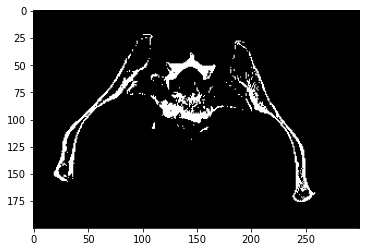

3
143
3
yolo
143
(3, 143)


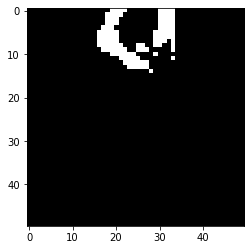

sum of pixels: 112


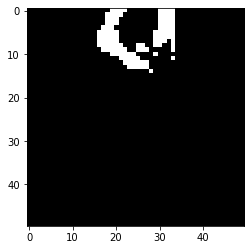

In [42]:
env = Center_FOV()
obs = env.reset()
plt.imshow(obs, cmap = 'gray')
#plt.colorbar()
plt.show()
print(f"sum of pixels: {np.sum(obs)}")

screen = env.render(mode = "rgb_array")
plt.imshow(screen, cmap = 'gray')
plt.show()
# cv2 does not work. 
# cv2.imshow("game", obs)
# cv2.waitKey(10)
# cv2.destroyAllWindows()

# this is now to test the Q-Table. 

In [76]:
def get_explore_rate(t,min_explore_rate,decay_fact):
    return max(min_explore_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))


def get_learning_rate(t,min_learning_rate,decay_fact):
    return max(min_learning_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))

In [79]:
# variables: 
neps = 20
tstep = 200
min_explore_rate = 0.1
min_learning_rate = 0.2
#grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
#decay_fact = np.prod(grid_size, dtype=float) / 10.0
decay_fact = 10/10.0
#state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
explore_rate = get_explore_rate(0,min_explore_rate,decay_fact)
learning_rate = get_learning_rate(0,min_learning_rate,decay_fact)

In [80]:
def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

In [118]:
#[5:38 PM, 4/22/2022] Natalie  Aw: I think it just makes sure that the grid and the screen are properly aligned
#[5:38 PM, 4/22/2022] Natalie  Aw: Cause the grid layer doesnt sit perfectly over the image

def state_to_bucket(state,env):
    grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= state_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_bounds[i][1]:
            bucket_index = grid_size[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = state_bounds[i][1] - state_bounds[i][0]
            offset = (grid_size[i]-1)*state_bounds[i][0]/bound_width
            scaling = (grid_size[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


In [116]:
def run_qlearn(env, explore_rate, learning_rate, neps=3,tstep=25, discount_factor = 0.99):
    env.render()
    
    print(env.canvas.size)
    print([env.action_space.n])
    q_table = np.random.uniform(low = -2, high = 0, size = (env.canvas.size[0], env.canvas.size[1], env.action_space.n))
    print(f'qtable shape: {q_table.shape}')


    for ep in range(neps):
        obv = env.reset()
        print(ep)
        state_0 = state_to_bucket(obv,env)
        total_reward = 0
        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward
            
            # update Q-table
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
            
            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.05)
            
            
            # update parameters
            #explore_rate = get_explore_rate(ep,min_explore_rate,decay_fact)
            #learning_rate = get_learning_rate(ep,min_learning_rate,decay_fact)
            
            if done:
                env.reset()
                print("Episode finished after {} timesteps".format(t+1))
                time.sleep(2)
                break
                
    return q_table

In [152]:
# My implementation

learning_rate = 0.1
env = Center_FOV()
def run_qlearn(env, explore_rate, learning_rate, num_episodes=5,total_steps=10, discount_factor = 0.99):


    env.render()
    
    #print(env.canvas.size)
    #print([env.action_space.n])
    # width, height = pil.size
    q_table = np.random.uniform(low = -2, high = 0, size = (env.canvas.size[1], env.canvas.size[0], env.action_space.n))
    print(f'qtable shape: {q_table.shape}')
    obs = env.reset()

    for episode in range(num_episodes):
        print(f'episode #: {episode}')
        # the states are tuples that index the q-table.   
        discrete_state = env.grabber.get_position()
        print(f'this is the coordinates: {env.grabber.get_position()}')

        done = False
        count = 0
        while not done or count < total_steps: 
            action = select_action(env, discrete_state, q_table, explore_rate)
            
            #env.step(action)
            obs, reward, done = env.step(action)  

            new_state = env.grabber.get_position()


            if not done: 
                max_future_q = np.max(q_table[new_state])
                current_q = q_table[discrete_state+(action,)]
                #print(max_future_q)
                #print(current_q)
                
                new_q = (1-learning_rate)*current_q + learning_rate*(reward+discount_factor*max_future_q)

                q_table[discrete_state+(action,)]=new_q
            
            # # if done, then 
            # elif done: 


            discrete_state = new_state


            #print(env.grabber.get_position(), reward)
            #print(reward, env.grabber.get_position())
            #env.render()
            count +=1

            #render every 24th step to see where we are.
            if count == total_steps - 1: 
                env.render()





def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

(0, 255)
0
0
250
200


C:\Users\asong18\Anaconda3\envs\deeplearning\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


(0, 255)
0
0
250
200


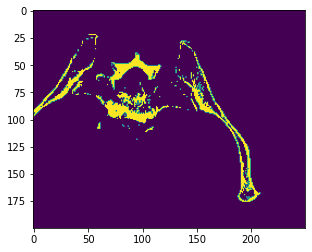

qtable shape: (200, 250, 5)


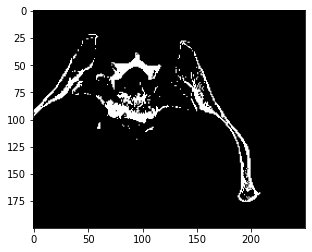

127
yolo
91
(127, 91)
episode #: 0
this is the coordinates: (127, 91)


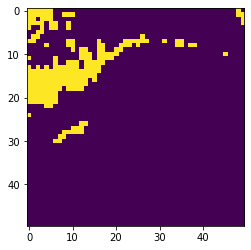

KeyboardInterrupt: 

In [153]:
fin_q_table = run_qlearn(Center_FOV(),explore_rate,learning_rate)

In [ ]:
# Plot Q Tables to see if it is learning anything. 

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
sns.heatmap(fin_q_table[:,:,3])
sns.set(font_scale=2)
ax.set_title('Q-Table for move West (left)')

In [ ]:
env = Center_FOV()
obs = env.reset()

plt.imshow(obs, cmap = 'gray')
#plt.colorbar()
plt.show()
print(env.)
print(f'position = {env.grabber.get_position.__ne__}')

# count = 0
# while True: 

#     # take random action
#     action = env.action_space.sample()
#     obs, reward, done = env.step(action)

#     print(f"current reward is: {reward}")

#     screen = env.render(mode = "rgb_array")
#     plt.imshow(screen, cmap = 'gray')
#     plt.show()
#     count +=1
#     if done == True or count == 10:
#         break
# env.close()


# while True: 

#     # take random action
#     action = env.action_space.sample()
#     obs, reward, done = env.step(action)

#     print(f"current reward is: {reward}")

#     screen = env.render(mode = "rgb_array")
#     plt.imshow(screen, cmap = 'gray')
#     plt.show()

#     if done == True:
#         break
# env.close()
        